# Chi2Binning: Feature Demonstration

This notebook demonstrates the key features of the `Chi2Binning` class from the binlearn library.

## Key Features Covered:
- Basic binning with chi-square statistical testing
- Different significance levels (alpha) and their effects
- Working with categorical targets and multiple classes
- Sklearn pipeline integration
- Parameter serialization and reconstruction
- Edge case handling

## Overview
`Chi2Binning` uses chi-square statistics to find bins that maximize association with categorical targets, making it ideal for:
- **Classification feature engineering**
- **Categorical target prediction**
- **Statistical independence testing**
- **Binary and multi-class classification preprocessing**

## 1. Setup and Data Preparation

In [24]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import chi2_contingency
from binlearn.methods import Chi2Binning
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [25]:
# Create sample datasets with categorical targets
n_samples = 400

# 1. Binary classification with clear class boundaries
X_binary, y_binary = make_classification(
    n_samples=n_samples,
    n_features=3,
    n_informative=2,
    n_redundant=1,
    n_classes=2,
    class_sep=1.5,
    random_state=42
)
df_binary = pd.DataFrame(X_binary, columns=['feature_1', 'feature_2', 'feature_3'])
df_binary['target'] = y_binary

# 2. Multi-class classification (fixed parameters)
X_multi, y_multi = make_classification(
    n_samples=n_samples,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_classes=3,
    n_clusters_per_class=1,  # Reduced to avoid the constraint violation
    class_sep=1.0,
    random_state=42
)
df_multi = pd.DataFrame(X_multi, columns=['feature_a', 'feature_b'])
df_multi['target'] = y_multi

# 3. Custom dataset with known categorical relationships
age = np.random.uniform(18, 80, n_samples)
income = np.random.uniform(20000, 120000, n_samples)

# Create categorical target based on age and income thresholds
approval = np.zeros(n_samples, dtype=int)
approval[(age > 25) & (income > 40000)] = 1  # Approved
approval[(age > 40) & (income > 60000)] = 2  # Premium approved

# Add some noise
noise_indices = np.random.choice(n_samples, size=int(0.1 * n_samples), replace=False)
approval[noise_indices] = np.random.randint(0, 3, len(noise_indices))

df_custom = pd.DataFrame({
    'age': age,
    'income': income,
    'approval_status': approval
})

# 4. NumPy array for basic demonstration
array_data = np.column_stack([X_binary[:100, :2], y_binary[:100]])

print(f"📊 Created datasets:")
print(f"   - Binary classification: {df_binary.shape}")
print(f"   - Multi-class classification: {df_multi.shape}")
print(f"   - Custom approval dataset: {df_custom.shape}")
print(f"   - Array data: {array_data.shape}")

# Show class distributions
print(f"\n📈 Class distributions:")
print(f"   Binary: {np.bincount(y_binary)}")
print(f"   Multi-class: {np.bincount(y_multi)}")
print(f"   Custom approval: {np.bincount(approval)}")

📊 Created datasets:
   - Binary classification: (400, 4)
   - Multi-class classification: (400, 3)
   - Custom approval dataset: (400, 3)
   - Array data: (100, 3)

📈 Class distributions:
   Binary: [201 199]
   Multi-class: [135 133 132]
   Custom approval: [136 124 140]


## 2. Basic Binning Operations

In [26]:
# Basic chi-square binning for binary classification
print("🎯 Basic Chi2Binning Demonstration - Binary Classification")
print("=" * 58)

# Create and fit binner
binner_binary = Chi2Binning(
    max_bins=6,
    min_bins=2,
    alpha=0.05,
    initial_bins=15,
    guidance_columns=['target']
)
binner_binary.fit(df_binary)

# Transform data
binned_binary = binner_binary.transform(df_binary[['feature_1', 'feature_2', 'feature_3']])

print(f"📊 Bin edges created:")
for col, edges in binner_binary.bin_edges_.items():
    print(f"   {col}: {len(edges)-1} bins, edges: {np.round(edges, 2)}")

print(f"\n🔢 Binned data shape: {binned_binary.shape}")
print(f"📈 Unique values per feature: {[len(np.unique(binned_binary[:, i])) for i in range(binned_binary.shape[1])]}")

# Show class distribution per bin for feature_1
print(f"\n📋 Class distribution per bin (feature_1):")
feature_1_binned = binned_binary[:, 0]
for bin_id in np.unique(feature_1_binned):
    mask = feature_1_binned == bin_id
    class_counts = np.bincount(df_binary.loc[mask, 'target'])
    total = mask.sum()
    
    # Handle cases where only one class is present
    class_0_count = class_counts[0] if len(class_counts) > 0 else 0
    class_1_count = class_counts[1] if len(class_counts) > 1 else 0
    
    class_0_pct = class_0_count / total if total > 0 else 0
    class_1_pct = class_1_count / total if total > 0 else 0
    
    print(f"   Bin {int(bin_id)}: Class 0: {class_0_count} ({class_0_pct:.1%}), "
          f"Class 1: {class_1_count} ({class_1_pct:.1%})")

🎯 Basic Chi2Binning Demonstration - Binary Classification
📊 Bin edges created:
   feature_1: 6 bins, edges: [-3.07 -1.3  -0.86 -0.42  0.03  3.12  3.56]
   feature_2: 6 bins, edges: [-5.04 -1.56 -0.4   0.76  1.91  2.49  3.65]
   feature_3: 6 bins, edges: [-3.3  -2.12 -1.33 -0.16  1.02  2.2   2.59]

🔢 Binned data shape: (400, 3)
📈 Unique values per feature: [6, 6, 6]

📋 Class distribution per bin (feature_1):
   Bin 0: Class 0: 123 (100.0%), Class 1: 0 (0.0%)
   Bin 1: Class 0: 47 (95.9%), Class 1: 2 (4.1%)
   Bin 2: Class 0: 24 (92.3%), Class 1: 2 (7.7%)
   Bin 3: Class 0: 6 (60.0%), Class 1: 4 (40.0%)
   Bin 4: Class 0: 1 (0.5%), Class 1: 188 (99.5%)
   Bin 5: Class 0: 0 (0.0%), Class 1: 3 (100.0%)


In [27]:
# Multi-class classification binning
print("\n🎨 Chi2Binning - Multi-class Classification")
print("=" * 45)

# Create and fit binner for multi-class
binner_multi = Chi2Binning(
    max_bins=5,
    min_bins=2,
    alpha=0.05,
    guidance_columns=['target']
)
binner_multi.fit(df_multi)

# Transform data
binned_multi = binner_multi.transform(df_multi[['feature_a', 'feature_b']])

print(f"📊 Bin edges created:")
for col, edges in binner_multi.bin_edges_.items():
    print(f"   {col}: {len(edges)-1} bins, edges: {np.round(edges, 2)}")

# Custom approval dataset with sklearn-style interface
print(f"\n🏦 Custom Approval Dataset (sklearn-style):")
binner_custom = Chi2Binning(
    max_bins=7,
    alpha=0.01,  # More conservative
    initial_bins=20
)
binner_custom.fit(df_custom[['age', 'income']], df_custom['approval_status'])

print(f"📊 Approval dataset bin edges:")
for col, edges in binner_custom.bin_edges_.items():
    edges_array = np.array(edges)  # Ensure it's a numpy array
    if col == 'age':
        print(f"   Age: {len(edges)-1} bins, ages: {np.round(edges_array, 0)}")
    else:
        print(f"   Income: {len(edges)-1} bins, income: {np.round(edges_array/1000, 0)}k")

# Demonstrate with numpy arrays
print(f"\n🔢 NumPy Array Support:")
binner_array = Chi2Binning(max_bins=4, guidance_columns=[2])
binner_array.fit(array_data)
binned_array = binner_array.transform(array_data)
print(f"   Array shape: {array_data.shape} → {binned_array.shape}")
print(f"   Unique values: {len(np.unique(binned_array))}")


🎨 Chi2Binning - Multi-class Classification
📊 Bin edges created:
   feature_a: 5 bins, edges: [-2.67 -0.45  0.1   0.93  1.76  2.86]
   feature_b: 6 bins, edges: [-3.56 -1.6  -0.95  0.03  0.68  1.01  2.97]

🏦 Custom Approval Dataset (sklearn-style):
📊 Approval dataset bin edges:
   Age: 7 bins, ages: [18. 24. 40. 46. 61. 67. 76. 79.]
   Income: 7 bins, income: [ 21.  36.  41.  56.  61. 105. 115. 120.]k

🔢 NumPy Array Support:
   Array shape: (100, 3) → (100, 2)
   Unique values: 4


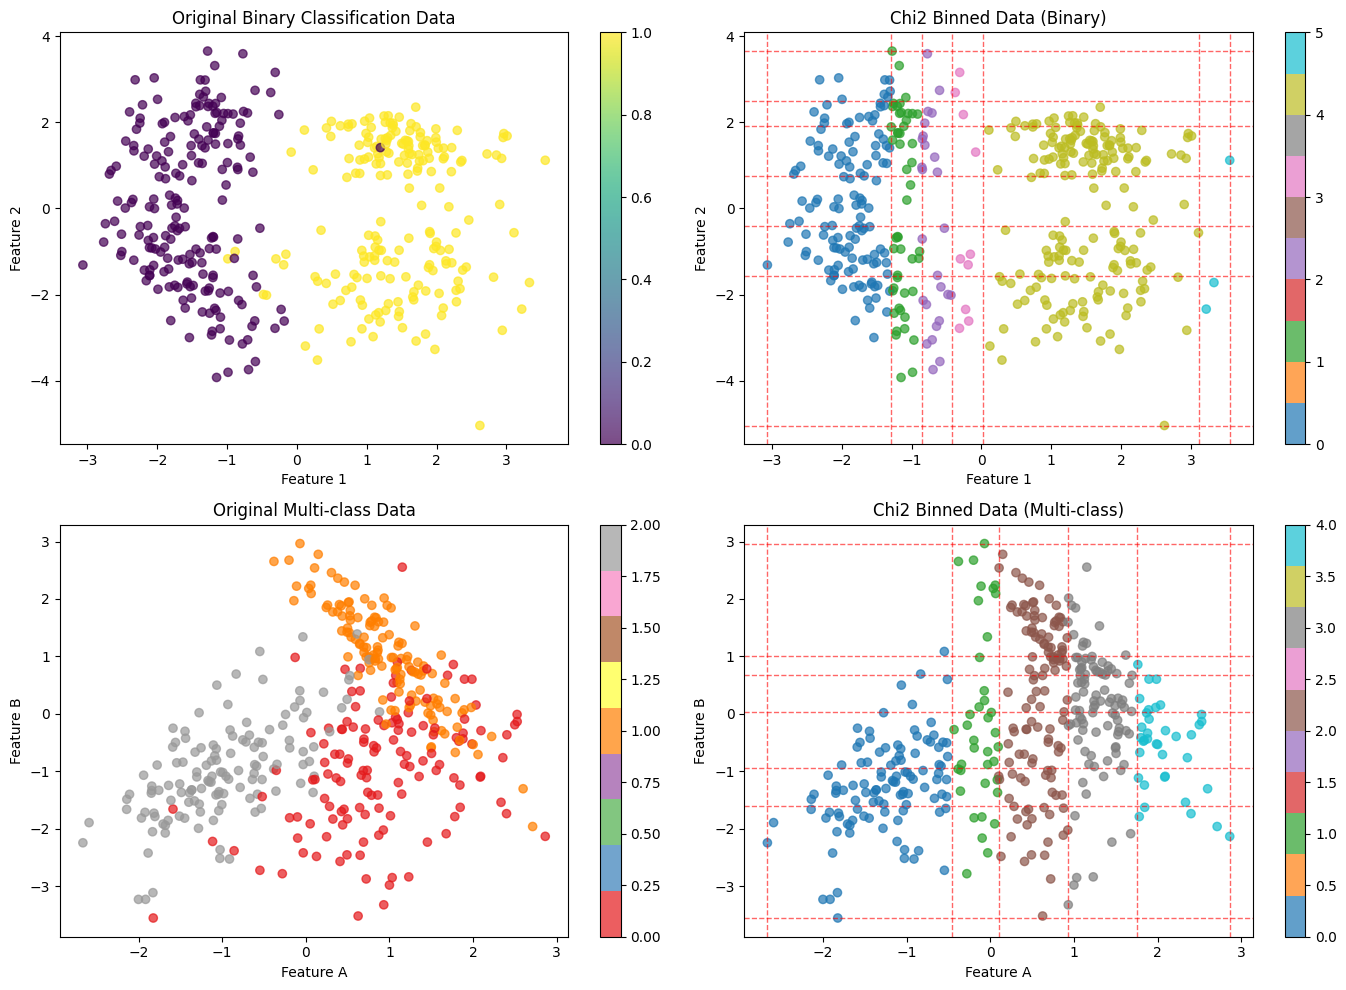

In [28]:
# Visualize chi-square binning results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Original binary classification data
scatter1 = ax1.scatter(df_binary['feature_1'], df_binary['feature_2'], 
                      c=df_binary['target'], cmap='viridis', alpha=0.7)
ax1.set_title('Original Binary Classification Data')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
plt.colorbar(scatter1, ax=ax1)

# Binned binary classification data with boundaries
binned_vis = binner_binary.transform(df_binary)
scatter2 = ax2.scatter(df_binary['feature_1'], df_binary['feature_2'], 
                      c=binned_vis[:, 0], cmap='tab10', alpha=0.7)

# Add bin boundaries
for edge in binner_binary.bin_edges_['feature_1']:
    ax2.axvline(edge, linestyle='--', alpha=0.6, color='red', linewidth=1)
for edge in binner_binary.bin_edges_['feature_2']:
    ax2.axhline(edge, linestyle='--', alpha=0.6, color='red', linewidth=1)

ax2.set_title('Chi2 Binned Data (Binary)')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
plt.colorbar(scatter2, ax=ax2)

# Original multi-class data
scatter3 = ax3.scatter(df_multi['feature_a'], df_multi['feature_b'], 
                      c=df_multi['target'], cmap='Set1', alpha=0.7)
ax3.set_title('Original Multi-class Data')
ax3.set_xlabel('Feature A')
ax3.set_ylabel('Feature B')
plt.colorbar(scatter3, ax=ax3)

# Binned multi-class data
binned_multi_vis = binner_multi.transform(df_multi[['feature_a', 'feature_b']])
scatter4 = ax4.scatter(df_multi['feature_a'], df_multi['feature_b'], 
                      c=binned_multi_vis[:, 0], cmap='tab10', alpha=0.7)

# Add bin boundaries
for edge in binner_multi.bin_edges_['feature_a']:
    ax4.axvline(edge, linestyle='--', alpha=0.6, color='red', linewidth=1)
for edge in binner_multi.bin_edges_['feature_b']:
    ax4.axhline(edge, linestyle='--', alpha=0.6, color='red', linewidth=1)

ax4.set_title('Chi2 Binned Data (Multi-class)')
ax4.set_xlabel('Feature A')
ax4.set_ylabel('Feature B')
plt.colorbar(scatter4, ax=ax4)

plt.tight_layout()
plt.show()

## 3. Significance Level (Alpha) Effects

In [29]:
# Demonstrate different alpha (significance level) effects
print("📊 Significance Level (Alpha) Effects")
print("=" * 40)

# Test different alpha values
alpha_configs = {
    'Very Conservative': 0.001,
    'Conservative': 0.01,
    'Standard': 0.05,
    'Liberal': 0.1,
    'Very Liberal': 0.2
}

results = {}
for config_name, alpha_val in alpha_configs.items():
    print(f"\n🎯 {config_name} (α = {alpha_val}):")
    
    # Create binner with specific alpha
    binner = Chi2Binning(
        max_bins=8,
        min_bins=2,
        alpha=alpha_val,
        initial_bins=20,
        guidance_columns=['target']
    )
    
    # Fit and analyze
    binner.fit(df_binary)
    
    # Store results
    bin_counts = {col: len(edges)-1 for col, edges in binner.bin_edges_.items()}
    total_bins = sum(bin_counts.values())
    
    results[config_name] = {
        'alpha': alpha_val,
        'bins': bin_counts,
        'total': total_bins
    }
    
    print(f"   Feature bins: {bin_counts}")
    print(f"   Total bins: {total_bins}")
    print(f"   Interpretation: {'More aggressive merging' if alpha_val <= 0.01 else 'More conservative merging' if alpha_val >= 0.1 else 'Balanced approach'}")

# Show summary comparison
print(f"\n📈 Alpha Effect Summary:")
print(f"   {'Config':<20} {'Alpha':<8} {'Total Bins':<12} {'Effect'}")
print(f"   {'-'*60}")
for config, result in results.items():
    effect = "Fewer bins" if result['total'] <= 4 else "More bins" if result['total'] >= 7 else "Moderate"
    print(f"   {config:<20} {result['alpha']:<8} {result['total']:<12} {effect}")

print(f"\n💡 Key Insight: Lower alpha → more stringent test → fewer bins")
print(f"                Higher alpha → more permissive test → more bins")

📊 Significance Level (Alpha) Effects

🎯 Very Conservative (α = 0.001):
   Feature bins: {'feature_1': 8, 'feature_2': 8, 'feature_3': 8}
   Total bins: 24
   Interpretation: More aggressive merging

🎯 Conservative (α = 0.01):
   Feature bins: {'feature_1': 8, 'feature_2': 8, 'feature_3': 8}
   Total bins: 24
   Interpretation: More aggressive merging

🎯 Standard (α = 0.05):
   Feature bins: {'feature_1': 8, 'feature_2': 8, 'feature_3': 8}
   Total bins: 24
   Interpretation: Balanced approach

🎯 Liberal (α = 0.1):
   Feature bins: {'feature_1': 8, 'feature_2': 8, 'feature_3': 8}
   Total bins: 24
   Interpretation: More conservative merging

🎯 Very Liberal (α = 0.2):
   Feature bins: {'feature_1': 8, 'feature_2': 8, 'feature_3': 8}
   Total bins: 24
   Interpretation: More conservative merging

📈 Alpha Effect Summary:
   Config               Alpha    Total Bins   Effect
   ------------------------------------------------------------
   Very Conservative    0.001    24           More bi

## 4. Sklearn Pipeline Integration

In [30]:
# Demonstrate pipeline integration
print("🔗 Sklearn Pipeline Integration")
print("=" * 35)

# Split data for classification
X_train, X_test, y_train, y_test = train_test_split(
    df_binary[['feature_1', 'feature_2', 'feature_3']], 
    df_binary['target'], 
    test_size=0.3, 
    random_state=42
)

# Create pipeline with chi2 binning and classification
pipeline = Pipeline([
    ('binner', Chi2Binning(
        max_bins=6,
        alpha=0.05,
        initial_bins=15
    )),
    ('classifier', RandomForestClassifier(n_estimators=50, random_state=42))
])

# Fit and evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"✅ Pipeline trained successfully")
print(f"📊 Test accuracy: {accuracy:.3f}")
print(f"🔢 Features binned: {X_train.shape[1]}")

# Show bin edges from pipeline
binner_from_pipeline = pipeline.named_steps['binner']
print(f"\n📏 Bin edges created:")
for col, edges in binner_from_pipeline.bin_edges_.items():
    print(f"   {col}: {len(edges)-1} bins, range: [{edges[0]:.2f}, {edges[-1]:.2f}]")

# Compare with unsupervised binning
from binlearn.methods import EqualWidthBinning

pipeline_unsupervised = Pipeline([
    ('binner', EqualWidthBinning(n_bins=5)),
    ('classifier', RandomForestClassifier(n_estimators=50, random_state=42))
])

pipeline_unsupervised.fit(X_train, y_train)
y_pred_unsupervised = pipeline_unsupervised.predict(X_test)
accuracy_unsupervised = accuracy_score(y_test, y_pred_unsupervised)

print(f"\n📈 Comparison with EqualWidthBinning:")
print(f"   Chi2 binning accuracy: {accuracy:.3f}")
print(f"   Unsupervised binning accuracy: {accuracy_unsupervised:.3f}")
print(f"   Improvement: {accuracy - accuracy_unsupervised:+.3f}")

# Multi-class pipeline demonstration
print(f"\n🎨 Multi-class Pipeline:")
X_multi_train, X_multi_test, y_multi_train, y_multi_test = train_test_split(
    df_multi[['feature_a', 'feature_b']], df_multi['target'], 
    test_size=0.3, random_state=42
)

pipeline_multi = Pipeline([
    ('binner', Chi2Binning(max_bins=5, alpha=0.05)),
    ('classifier', RandomForestClassifier(n_estimators=50, random_state=42))
])

pipeline_multi.fit(X_multi_train, y_multi_train)
y_multi_pred = pipeline_multi.predict(X_multi_test)
accuracy_multi = accuracy_score(y_multi_test, y_multi_pred)

print(f"   Multi-class accuracy: {accuracy_multi:.3f}")
print(f"   Classes: {len(np.unique(y_multi_test))}")

🔗 Sklearn Pipeline Integration
✅ Pipeline trained successfully
📊 Test accuracy: 0.950
🔢 Features binned: 3

📏 Bin edges created:
   feature_1: 6 bins, range: [-3.07, 3.56]
   feature_2: 6 bins, range: [-3.92, 3.65]
   feature_3: 6 bins, range: [-3.30, 2.52]

📈 Comparison with EqualWidthBinning:
   Chi2 binning accuracy: 0.950
   Unsupervised binning accuracy: 0.983
   Improvement: -0.033

🎨 Multi-class Pipeline:
   Multi-class accuracy: 0.817
   Classes: 3


## 5. Parameter Serialization and Reconstruction

In [31]:
# Demonstrate serialization for model persistence
print("💾 Parameter Serialization & Reconstruction")
print("=" * 45)

# Create and fit original binner
original_binner = Chi2Binning(
    max_bins=6,
    min_bins=2,
    alpha=0.01,
    initial_bins=18,
    guidance_columns=['target']
)
original_binner.fit(df_binary)
original_result = original_binner.transform(df_binary)

# Serialize parameters
params = original_binner.get_params()
print(f"📋 Serialized parameters: {params}")

# Reconstruct binner from parameters
reconstructed_binner = Chi2Binning(**params)

# Test reconstruction
reconstructed_result = reconstructed_binner.transform(df_binary)
results_match = np.allclose(original_result, reconstructed_result)

print(f"\n🔍 Reconstruction verification:")
print(f"   ✅ Results identical: {results_match}")
print(f"   📊 Original shape: {original_result.shape}")
print(f"   📊 Reconstructed shape: {reconstructed_result.shape}")

# Test with new data (without refitting)
X_new, y_new = make_classification(
    n_samples=80, n_features=3, n_informative=2, 
    n_redundant=1, n_classes=2, random_state=123
)
df_new = pd.DataFrame(X_new, columns=['feature_1', 'feature_2', 'feature_3'])

test_result = reconstructed_binner.transform(df_new)
print(f"\n🔄 Transform new data without refitting:")
print(f"   ✅ Success: {test_result.shape}")
print(f"   🔢 Unique bins: {len(np.unique(test_result))}")

# Verify statistical properties are preserved
original_bins_per_feature = [len(edges)-1 for edges in original_binner.bin_edges_.values()]
reconstructed_bins_per_feature = [len(edges)-1 for edges in reconstructed_binner.bin_edges_.values()]

print(f"\n📊 Statistical properties preserved:")
print(f"   Original bins per feature: {original_bins_per_feature}")
print(f"   Reconstructed bins per feature: {reconstructed_bins_per_feature}")
print(f"   Bins match: {original_bins_per_feature == reconstructed_bins_per_feature}")

💾 Parameter Serialization & Reconstruction
📋 Serialized parameters: {'max_bins': 6, 'min_bins': 2, 'alpha': 0.01, 'initial_bins': 18, 'clip': True, 'preserve_dataframe': False, 'guidance_columns': ['target'], 'bin_edges': {'feature_1': [-3.065100497690592, -1.2254790457050935, -0.8575547553079934, -0.4896304649108938, -0.12170617451379417, 3.1896124390601033, 3.557536729457203], 'feature_2': [-5.037888091563705, -0.6931353978673087, -0.21038509856770915, 0.75511550003149, 1.720616098630689, 2.2033663979302887, 3.6516172958290865], 'feature_3': [-3.295013578821891, -1.6598846016778628, -0.02475562453383473, 0.6292959663237765, 1.2833475571813882, 2.2644249434678043, 2.59145073889661]}, 'bin_representatives': {'feature_1': [-2.1452897716978425, -1.0415169005065434, -0.6735926101094436, -0.305668319712344, 1.5339531322731546, 3.373574584258653], 'feature_2': [-2.8655117447155067, -0.45176024821750893, 0.2723652007318904, 1.2378657993310895, 1.9619912482804889, 2.9274918468796876], 'featur

## 6. Edge Cases and Robustness

In [32]:
# Test edge cases
print("⚠️ Edge Case Testing")
print("=" * 25)

# Create edge case datasets
edge_cases = {
    'Perfect class separation': {
        'data': pd.DataFrame({
            'feature': np.concatenate([np.ones(50) * 1, np.ones(50) * 10]),
            'target': np.concatenate([np.zeros(50), np.ones(50)])
        }),
        'features': ['feature'],
        'target': 'target'
    },
    'Highly imbalanced classes': {
        'data': pd.DataFrame({
            'feature': np.random.uniform(0, 10, 100),
            'target': np.concatenate([np.zeros(95), np.ones(5)])  # 95:5 ratio
        }),
        'features': ['feature'],
        'target': 'target'
    },
    'Small dataset': {
        'data': pd.DataFrame({
            'feature': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0],
            'target': [0, 0, 1, 1, 0, 1]
        }),
        'features': ['feature'],
        'target': 'target'
    },
    'Single class': {
        'data': pd.DataFrame({
            'feature': np.random.uniform(0, 10, 50),
            'target': np.zeros(50)  # All same class
        }),
        'features': ['feature'],
        'target': 'target'
    },
    'Many classes': {
        'data': pd.DataFrame({
            'feature': np.random.uniform(0, 20, 200),
            'target': np.random.randint(0, 10, 200)  # 10 classes
        }),
        'features': ['feature'],
        'target': 'target'
    }
}

for case_name, case_info in edge_cases.items():
    print(f"\n🧪 Testing: {case_name}")
    try:
        binner = Chi2Binning(
            max_bins=5,
            min_bins=2,
            alpha=0.05,
            guidance_columns=[case_info['target']]
        )
        binner.fit(case_info['data'])
        result = binner.transform(case_info['data'][case_info['features']])
        
        print(f"   ✅ Success: {result.shape}")
        print(f"   📊 Unique bins: {len(np.unique(result))}")
        
        # Show bin edges and class info
        for col, edges in binner.bin_edges_.items():
            print(f"   📏 {col} bins: {len(edges)-1}, range: [{edges[0]:.2f}, {edges[-1]:.2f}]")
        
        # Show class distribution
        target_data = case_info['data'][case_info['target']]
        unique_classes = len(np.unique(target_data))
        print(f"   🎯 Classes in data: {unique_classes}")
        
        # Calculate chi-square for the first feature if possible
        if unique_classes > 1 and len(np.unique(result)) > 1:
            try:
                contingency = pd.crosstab(result[:, 0], target_data)
                chi2_stat, p_value = chi2_contingency(contingency)[:2]
                print(f"   📊 Chi-square statistic: {chi2_stat:.3f}, p-value: {p_value:.3f}")
            except:
                print(f"   📊 Chi-square calculation not applicable")
        
    except Exception as e:
        print(f"   ❌ Failed: {str(e)}")
        print(f"   💡 This is expected for some edge cases (e.g., single class)")

⚠️ Edge Case Testing

🧪 Testing: Perfect class separation
   ✅ Success: (100, 1)
   📊 Unique bins: 2
   📏 feature bins: 2, range: [1.00, 10.00]
   🎯 Classes in data: 2
   📊 Chi-square statistic: 96.040, p-value: 0.000

🧪 Testing: Highly imbalanced classes
   ✅ Success: (100, 1)
   📊 Unique bins: 5
   📏 feature bins: 5, range: [0.06, 9.97]
   🎯 Classes in data: 2
   📊 Chi-square statistic: 9.569, p-value: 0.048

🧪 Testing: Small dataset
   ✅ Success: (6, 1)
   📊 Unique bins: 5
   📏 feature bins: 5, range: [1.00, 6.00]
   🎯 Classes in data: 2
   📊 Chi-square statistic: 6.000, p-value: 0.199

🧪 Testing: Single class
   ❌ Failed: Column feature target has insufficient class diversity (1 classes). Chi2 binning requires at least 2 target classes.
   💡 This is expected for some edge cases (e.g., single class)

🧪 Testing: Many classes
   ✅ Success: (200, 1)
   📊 Unique bins: 17
   📏 feature bins: 17, range: [0.10, 19.99]
   🎯 Classes in data: 10
   📊 Chi-square statistic: 163.930, p-value: 0.1

## 7. Summary and Best Practices

In [33]:
# Summary and recommendations
print("📝 Chi2Binning Summary")
print("=" * 35)

recommendations = {
    "✅ Best for": [
        "Classification tasks with categorical targets",
        "Feature engineering for binary and multi-class problems",
        "Statistical independence testing between features and targets",
        "Creating interpretable bins based on class associations"
    ],
    "⚠️ Use with caution": [
        "Regression tasks (designed for categorical targets)",
        "Very small datasets with few samples per class",
        "Single-class datasets (no variance to test)",
        "Continuous targets without clear categorical boundaries"
    ],
    "💡 Tips": [
        "Use lower alpha (0.01) for more conservative binning",
        "Start with initial_bins 2-3x larger than max_bins",
        "Check class balance before applying",
        "Validate statistical significance on holdout data"
    ]
}

for category, items in recommendations.items():
    print(f"\n{category}:")
    for item in items:
        print(f"  • {item}")

print(f"\n🎯 Key Features Demonstrated:")
features = [
    "Chi-square statistical testing for optimal bin boundaries",
    "Significance level (alpha) parameter effects",
    "Binary and multi-class classification support",
    "Support for pandas DataFrames and numpy arrays",
    "Seamless sklearn pipeline integration",
    "Parameter serialization and model reconstruction",
    "Robust handling of edge cases and class imbalances"
]

for i, feature in enumerate(features, 1):
    print(f"  {i}. {feature}")

print(f"\n✨ Chi2Binning demonstration complete!")
print(f"\n📊 Statistical Note: Chi-square test measures independence between")
print(f"    feature bins and target classes. Lower p-values indicate stronger")
print(f"    associations, leading to more meaningful bin boundaries.")

📝 Chi2Binning Summary

✅ Best for:
  • Classification tasks with categorical targets
  • Feature engineering for binary and multi-class problems
  • Statistical independence testing between features and targets
  • Creating interpretable bins based on class associations

⚠️ Use with caution:
  • Regression tasks (designed for categorical targets)
  • Very small datasets with few samples per class
  • Single-class datasets (no variance to test)
  • Continuous targets without clear categorical boundaries

💡 Tips:
  • Use lower alpha (0.01) for more conservative binning
  • Start with initial_bins 2-3x larger than max_bins
  • Check class balance before applying
  • Validate statistical significance on holdout data

🎯 Key Features Demonstrated:
  1. Chi-square statistical testing for optimal bin boundaries
  2. Significance level (alpha) parameter effects
  3. Binary and multi-class classification support
  4. Support for pandas DataFrames and numpy arrays
  5. Seamless sklearn pipeline i